In [41]:
# Do a pseudo code for vectorize photos of zeros and ones
# use SVD and PCA
# do the algebra logic by "hand", dont use scikit-learn
import os
import numpy as np
import matplotlib.pyplot as plt
# to load images without PIL
import cv2
from PIL import Image

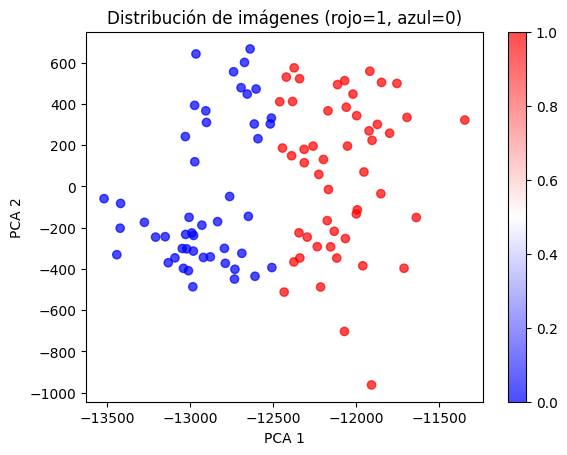

Imágenes clasificadas como '1': 50
Imágenes clasificadas como '0': 48


In [60]:
# Procedimento:
# - cargar todas las imagenes jpeg del directorio ./fotos/
# - convertir a escala de grises
# - transformar aumentando el contraste y disminuyendo el tamaño (quitar bordes)
# - vectorizar cada imagen
# - construir una matriz cuyas filas sean cada vector
# - Analizar con PCA y mostrar graficamente cuántas imagenes don '1' y cuántas son '0'

ruta = "./fotos/"
imagenes = []
for archivo in os.listdir(ruta):
    if archivo.endswith(".jpeg"):
        img = cv2.imread(os.path.join(ruta, archivo), cv2.IMREAD_GRAYSCALE)  # 2. Convertir a escala de grises
        if img is not None:
            img = cv2.resize(img, (75, 75))  # 3. Reducir tamaño
            imagenes.append(img.flatten())  # 4. Vectorizar la imagen

# usamos la descomposición U * S * V_t = X
X = np.array(imagenes)  # 5. Construir matriz X
U, S, Vt = np.linalg.svd(X, full_matrices=False)  # 6. Descom

X_pca = X @ Vt.T[:, :2]  # Reducimos a 2 componentes principales para visualización

# 7. Clasificación simple: '1' si PC1 > media, '0' en caso contrario
umbral = np.mean(X_pca[:, 0])
etiquetas = (X_pca[:, 0] > umbral).astype(int)

# 8. Visualización de la clasificación
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=etiquetas, cmap='bwr', alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Distribución de imágenes (rojo=1, azul=0)")
plt.colorbar()
plt.show()

# Contar cuántas imágenes son '1' y cuántas son '0'
num_1 = np.sum(etiquetas)
num_0 = len(etiquetas) - num_1
print(f"Imágenes clasificadas como '1': {num_1}")
print(f"Imágenes clasificadas como '0': {num_0}")


Se han cargado 98 imágenes con 2500 características cada una.


c:\Users\Sebastian\Documents\GitHub\classical_trajectory\svdpca.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Sebastian\Documents\GitHub\classical_trajectory\svdpca.venv\Lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


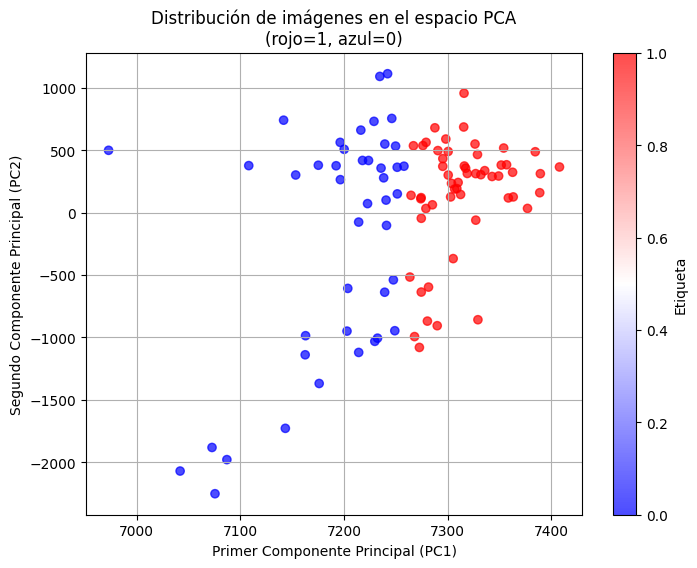

Imágenes clasificadas como '1': 55
Imágenes clasificadas como '0': 43


In [ ]:
# Importamos las librerías necesarias
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Función para cargar, procesar y vectorizar imágenes
def cargar_procesar_imagenes(directorio, nuevo_tam=(50, 50)):
    imagenes_vectorizadas = []
    
    for archivo in os.listdir(directorio):
        if archivo.endswith(".jpeg"):
            # Cargar imagen en escala de grises
            ruta_imagen = os.path.join(directorio, archivo)
            img = cv2.imread(ruta_imagen, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Reducir el tamaño de la imagen
                img_redimensionada = cv2.resize(img, nuevo_tam)
                # Aumentar contraste usando equalización de histograma
                img_contraste = cv2.equalizeHist(img_redimensionada)
                # Vectorizar la imagen (convertir la matriz en un vector)
                imagenes_vectorizadas.append(img_contraste.flatten())
    
    return np.array(imagenes_vectorizadas)

# 1. Cargar y procesar las imágenes del directorio './fotos/'
directorio = "./fotos/"
X = cargar_procesar_imagenes(directorio)

# Verificamos que se hayan cargado imágenes
if X.shape[0] == 0:
    print("No se encontraron imágenes .jpeg en el directorio especificado.")
else:
    print(f"Se han cargado {X.shape[0]} imágenes con {X.shape[1]} características cada una.")

# 2. Estandarización: centramos los datos (restamos la media de cada característica)
X_mean = np.mean(X, axis=0)
X_centered = X - X_mean / 255.0

# 3. No usar la matriz de covarianza, sino la matriz de productos internos
XtX = X_centered.T @ X_centered

# 4. Calcular los vectores y valores propios de la matriz de productos internos
eigvals, eigvecs = np.linalg.eig(XtX)


# 5. Ordenar los valores propios y vectores en orden descendente
indices_orden = np.argsort(eigvals)[::-1]
eigvals = eigvals[indices_orden]
eigvecs = eigvecs[:, indices_orden]

# 6. Seleccionar los 2 primeros componentes principales para visualización
PCs = eigvecs[:, :2]

# 7. Proyección de los datos en el espacio de los componentes principales
X_pca = X_centered @ PCs

# 8. Clasificación simple: '1' si PC1 > media, '0' en caso contrario
umbral = np.mean(X_pca[:, 0])
etiquetas = (X_pca[:, 0] > umbral).astype(int)

# 8. Visualización: scatter plot de las proyecciones PCA
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=etiquetas, cmap='bwr', alpha=0.7)
plt.xlabel("Primer Componente Principal (PC1)")
plt.ylabel("Segundo Componente Principal (PC2)")
plt.title("Distribución de imágenes en el espacio PCA\n(rojo=1, azul=0)")
plt.colorbar(scatter, label="Etiqueta")
plt.grid(True)
plt.show()

# 9. Mostrar la cantidad de imágenes clasificadas como '1' y '0'
num_1 = np.sum(etiquetas)
num_0 = len(etiquetas) - num_1
print(f"Imágenes clasificadas como '1': {num_1}")
print(f"Imágenes clasificadas como '0': {num_0}")

In [62]:
# mostrar la primera imagen como un vector
print(X[0])


[187 187 188 ... 149 151 151]
